# Watershed Models

## Model Description 
This whole model will run three scenarios:
1. NANT: where there is no agriculture and no farm (meaning the watershed is at a steady state natural system)
2. NAYT: where agriculture is still turned off (there is no agriculture well) and the town is pumping water
3. YAYT: This scenario has both agriculture and the town (the fully formed scenario)

#### Dimensions: 
- 50 by 50 by 3 
- dx = dy = 1000 m
- dz = 100 m  

#### Topography
- This catchment is a mountainous watershed with mountains on the left side of the domain and lowlands on the right
- The top and bottom left corners are no flow areas due to bedrock
- The bottom layer is 40 m thick, the middle 5 m and the top goes up to the elevation 

#### Subsurface Properties: 
- Homogeneous 
- K = 10 m/day in x, y for the top layer and 0.0001 m/day for the left most columns in the bottom 2 layers
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001  

#### Stream Properties: 
- stream is in row 25
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.001 m/m
- Streambed rough = 0.04
- Streambed width = 1 m
- Streambed K =  1000 m/day 
- Streambed thickness = 1 m
- Stream bottom depth = 1 m
- Stage = 0.5


#### Boundary Conditions: 
 - Right boundary is 70m
 - Left boundary is a constant head representing a lake.


#### Surface Properties
- Recharge occurs at a rate of 4E-5 m/day in the leftmost 15 columns and is zero elsewhere.
- ET is zero in the left half of the domain. 
- ET is 1E-5 m/day in the right half of the domain. 
- ET occurs at a rate of 5E-4 m/day in a riparian area that extends from the left boundary to the right boundary and occupies rows 22 to 28, inclusive.
- The extinction depth is 1 m everywhere.

# Set up the environment

In [76]:
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import flopy.utils.binaryfile as bf

%matplotlib inline

# User inputs

In [77]:
# Set up all the Inputs that we would need to make sure that this will work well
modelname = "str_model"
moddir="/Applications/MODFLOW/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)


nrow = 50
ncol = 50
dx = 1000
dy = 1000
ztop = 10
zbot = 0.

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

## Make Three Layers 
nlay=3  #three layers instead of 1
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 35 m 

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)


zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

## Subsurface properties
K_horiz = 10    #assign horizontal hydraulic conductivity 
K_vert = 10    #assign vertical hydraulic conductivity (along z axis)
## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:ncol] = 20                  # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array


dz = (ztop - zbot) / nlay
Lx = dx*ncol
Ly = dy*nrow

nper = 1
steady = [True]

# Initialize heads
h_right = 70

# Setup the MODFLOW Packages other than the stream package

/opt/miniconda3/envs/gwnew37/lib/python3.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


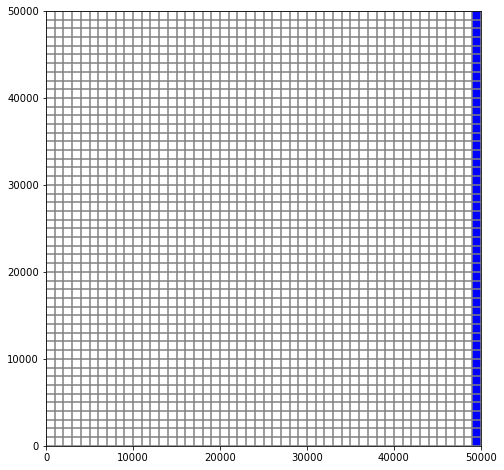

In [78]:
# Name model
modelname1 = "NANT"

m_NANT = flopy.modflow.Modflow(modelname1, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m_NANT, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,49] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head

#ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

# Set up noflow boundary in ibounds



# # Top Left Corner
# # layer One
# ibound[:,0,0:6] = 0
# ibound[:,1,0:5] = 0
# ibound[:,2,0:4] = 0
# ibound[:,3, 0:3] = 0
# ibound[:, 4, 0:2] = 0
# ibound[:,5, 0:1] = 0


# #Layer 2
# ibound[1:1,0,6:8] = 0
# ibound[1:1,1,5:7] = 0
# ibound[1:1,2,4:6] = 0
# ibound[1:1,3, 3:5] = 0
# ibound[1:1, 4, 2:4] = 0
# ibound[1:1,5, 1:3] = 0
# ibound[1:1,6, 0:2] = 0
# ibound[1:1,7, 0:1] = 0
# ibound[1:1,8, 0] = 0

# #Layer 3
# ibound[2,0,5:10] = 0
# ibound[2,1,4:9] = 0
# ibound[2,2,3:8] = 0
# ibound[2,3, 2:7] = 0
# ibound[2, 4, 1:6] = 0
# ibound[2,5, 0:5] = 0
# ibound[2,6, 0:4] = 0
# ibound[2,7, 0:3] = 0
# ibound[2,8, 0:2] = 0
# ibound[2,9, 0:1] = 0
# ibound[2,10, 0] = 0

# # Bottom Left
# # layer One
# ibound[:,49,0:6] = 0
# ibound[:,48,0:5] = 0
# ibound[:,47,0:4] = 0
# ibound[:,46, 0:3] = 0
# ibound[:, 45, 0:2] = 0
# ibound[:,44,0] = 0

# #Layer 2
# ibound[1:49,0,6:8] = 0
# ibound[1:48,1,5:7] = 0
# ibound[1:47,2,4:6] = 0
# ibound[1:46,3, 3:5] = 0
# ibound[1:45, 4, 2:4] = 0
# ibound[1:44,5, 1:3] = 0
# ibound[1:43,6, 0:2] = 0
# ibound[1:42,7, 0:1] = 0


# #Layer 3
# ibound[2,49,5:10] = 0
# ibound[2,48,4:9] = 0
# ibound[2,47,3:8] = 0
# ibound[2,46, 2:7] = 0
# ibound[2, 45, 1:6] = 0
# ibound[2,44, 0:5] = 0
# ibound[2,43, 0:4] = 0
# ibound[2,42, 0:3] = 0
# ibound[2,41, 0:2] = 0
# ibound[2,40, 0:1] = 0

# ## Other Boundaries are no flow so we make all those cells inactive
# ibound[:, :, 0] = 0
# ibound[:,0, :] = 0
# ibound[:,-1, :] = 0



#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, -1] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas=flopy.modflow.ModflowBas(model = m_NANT, ibound=ibound, strt=H_init)


#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m_NANT, mxiter=1000, iter1=2000, relax = 0.7, damp = 0.7)

#LPF object
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)      #defining conductivity in m/d
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

# Define Layer Properties for LPF Files
ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 0.001 #assign storage coefficient
n = 0.1        #assign porosity   
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

lpf = flopy.modflow.ModflowLpf(model = m_NANT, laytyp=uncnf, hk=hk, vka=vk, ss=ss,sy=Sy,storagecoefficient=True, ipakcb=53) 

# Rch object 
# Recharge is only in the left half of hte domain
recharge = 4e-5 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[0:16,:]=rech_zone[0:16,:]+recharge
#rch = flopy.modflow.mfrch.ModflowRch(model=m_NANT, rech=rech_zone, ipakcb=53)     #create rch object

#ET Object
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
riv_et = 5e-4  #set background ET value m/day
back_et = 1e-5
ET_zone[:, 25:49] = ET_zone[:, 25:49] +back_et
ET_zone[21:29,:] = ET_zone[21:29,:] + riv_et  #apply riv et to the right section
extinction_depth = 1

#evt = flopy.modflow.mfevt.ModflowEvt(model=m_NANT, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 


# Plot ibound
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m_NANT)
ibound = mapview.plot_ibound()
# wel = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()



# Setup the stream! Define STR object

In [79]:
# Streambed thickness and width do not necessarily align with the grid cell values
# This package is a head dependent flux package!
# User inputs:
k_strbott = 3280.84                    #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
str_bott = 1                      #river bottom
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# calculated values
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
cond_vals = np.ones(nrow)
cond_vals[0:20] = cond/100
cond_vals[21:26] = cond/10
cond_vals[27:-1] = cond

str_top = str_bott+sed_thick
str_stage = Stage_above_datum

if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
    print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
# Has to be a loop because we need to have all these values for each reach (ie each grid cell)!
strd = {}  
strspd = []
for x in range(ncol): # should loop from 0 to 49
    add = [0, nrow/2, x, 1, x+1, Flow_into_the_1st_reach, str_stage, cond_vals[x], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd  
#print(strspd)
 
# Will need to have two segments in the next HW because we have recharge happening into the river from the farm..... yay!
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

# strm = flopy.modflow.mfstr.ModflowStr(m_NANT, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
#         stress_period_data=strd, segment_data=str_segd, extension='str') 

Calculated stage at inflow = 2.0


# Plot model grid and boundary conditions

AttributeError: 'NoneType' object has no attribute 'parent'

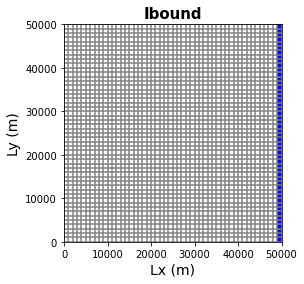

In [80]:
modelmap = flopy.plot.PlotMapView(model=m_NANT, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

# Write MODFLOW input files and run the model

In [ ]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

AttributeError: 'NoneType' object has no attribute 'nstp'

# Plot stream related results 

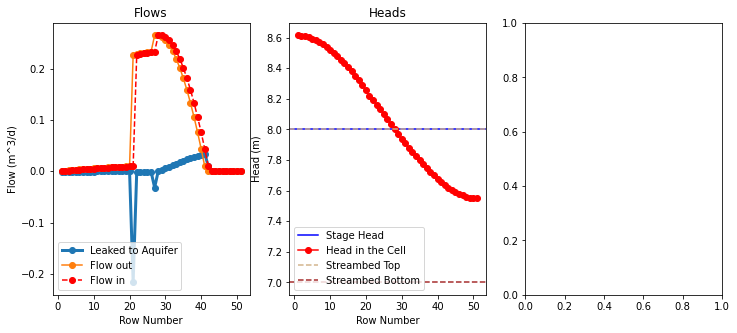

In [ ]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
#Preparing variables for plotting 
leakage = leak[0]
str_outflow = str_outflow[0]
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow['q']
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])

#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
#ax.set_aspect('equal')
ax1.set_title('Flows')
ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow['q'], label="Flow out", marker='o') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='o') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()

#####################################################################
# Plotting reach wise heads
ax2.set_title('Heads')
ax2.axhline(y=str_stage,  color='blue', label="Stage Head")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='o') 
ax2.axhline(y=str_top,  color='tan', linestyle='--', label="Streambed Top")
ax2.axhline(y=str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()

# Plot head distribution

/opt/miniconda3/envs/gwnew37/lib/python3.7/site-packages/flopy/plot/map.py:823: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  DeprecationWarning,
/opt/miniconda3/envs/gwnew37/lib/python3.7/site-packages/flopy/plot/plotutil.py:1634: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  DeprecationWarning,


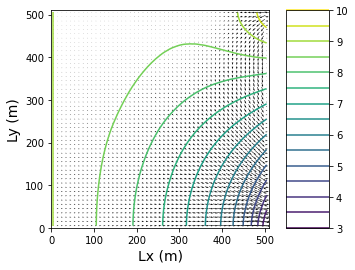

In [ ]:
#####################################################################
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)